# UCI regression eval

In [1]:
import jax
import os
import re
import datagen
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "EKF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold",
    "OGD": "blueviolet",
    "EKF-B": "darkorange",
}

In [28]:
from matplotlib import colors
cmap_rgb = {
    c: colors.cnames[v]
    for c, v in cmap.items()
}
cmap_rgb

{'EKF-IW': '#DC143C',
 'WLF-IMQ': '#1E90FF',
 'EKF': '#20B2AA',
 'WLF-MD': '#FFD700',
 'OGD': '#8A2BE2',
 'EKF-B': '#FF8C00'}

In [29]:
path_base = "./results"
# experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error" not in f)]
experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error10" in f)]
sorted(experiment_names)

info_datasets = []
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    nrows, ncols = dataset.shape
    
    info_datasets.append({
        "dataset": dataset_name.split("-")[0].capitalize(),
        "nrows": nrows,
        "ncols": ncols
    })

info_datasets = pd.DataFrame(info_datasets).sort_values("dataset")
info_datasets

,dataset,nrows,ncols
3,Bostonhousing,507,14
5,Concrete,1031,9
6,Energy,769,9
7,Kin8nm,8193,9
1,Naval,11935,18
4,Power,9569,5
0,Protein,45731,10
2,Wine,1600,12
8,Yacht,309,7


In [82]:
df_results_all = []
for file_name in experiment_names:
    dataset = file_name.replace("-target.pkl", "")
    path = os.path.join(path_base, file_name)
    with open(path, "rb") as f:
        experiment = pickle.load(f)

    errors = jax.tree_map(lambda x: np.power(x - experiment["datasets"]["y"], 2), experiment["posterior-states"])
    
    running_times = experiment["time"].copy()
    # del running_times["EKF-B"]    # REMOVE AFTER REFACTORING
    running_times = pd.DataFrame(running_times)

    df_results = pd.DataFrame({
        name: np.median(errors[name], axis=1)
        for name in errors
    })

    df_results = df_results.reset_index().melt("index", value_name="err")
    running_times = running_times.reset_index().melt("index", value_name="time")
    
    df_results = pd.merge(
        df_results,
        running_times,
        on=["index", "variable"],
    )
    
    df_results["dataset"] = dataset
    df_results_all.append(df_results)

df_results_all = pd.concat(df_results_all, axis=0)

# Root median squared error
df_results_all["err"] = np.sqrt(df_results_all["err"])
df_results_all["dataset"] = df_results_all["dataset"].str.replace("-.*", "", regex=True).str.capitalize()
df_results_all = df_results_all.rename({"index": "run", "variable": "method"}, axis=1)
df_results_all = df_results_all.merge(info_datasets, on="dataset")
df_results_all["method"] = df_results_all["method"].apply(lambda x: x.replace("KF", "EKF"))

df_results_all = df_results_all.query("run > 0")

In [84]:
df_results_all.sample(10, random_state=314)

,run,method,err,time,dataset,nrows,ncols
1814,14,EKF,1.353681,0.009794,Bostonhousing,507,14
4888,88,EKF,0.547524,0.221540,Naval,11935,18
2019,19,EKF-IW,0.307579,0.070247,Bostonhousing,507,14
3836,36,EKF-IW,0.149314,0.286073,Wine,1600,12
1630,30,WLF-IMQ,0.192020,0.115939,Kin8nm,8193,9
1795,95,WLF-MD,0.194348,0.116111,Kin8nm,8193,9
2737,37,OGD,0.388599,0.068160,Power,9569,5
2446,46,EKF,0.519065,0.111640,Power,9569,5
1964,64,EKF-B,0.197038,0.086596,Bostonhousing,507,14
3896,96,EKF-IW,0.146038,0.285875,Wine,1600,12


In [85]:
df_results_all["timestep"] = df_results_all["time"] / (df_results_all["nrows"]) * 1e6

In [86]:
datasets = sorted(df_results_all.dataset.unique())
print(datasets)

['Bostonhousing', 'Concrete', 'Energy', 'Kin8nm', 'Naval', 'Power', 'Protein', 'Wine', 'Yacht']


In [87]:
df_results_all.pivot_table(columns="method", index="dataset", values="err", aggfunc="median")

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,1.365663,0.201237,0.205200,0.530749,0.193207,0.202967
Concrete,0.751237,0.237412,0.237755,0.424976,0.235232,0.238478
Energy,0.848607,0.390911,0.386731,0.590109,0.390130,0.389251
Kin8nm,0.518565,0.196640,0.199704,0.426767,0.197654,0.196755
Naval,0.541604,0.305352,0.308743,0.336644,0.307138,0.307119
Power,0.515047,0.268043,0.268153,0.385962,0.267539,0.268103
Protein,0.449905,0.284180,0.278144,0.360105,0.190890,0.186785
Wine,0.744419,0.147741,0.148991,0.391822,0.148226,0.148283
Yacht,1.126461,0.239606,0.137618,0.544987,0.259142,0.247963


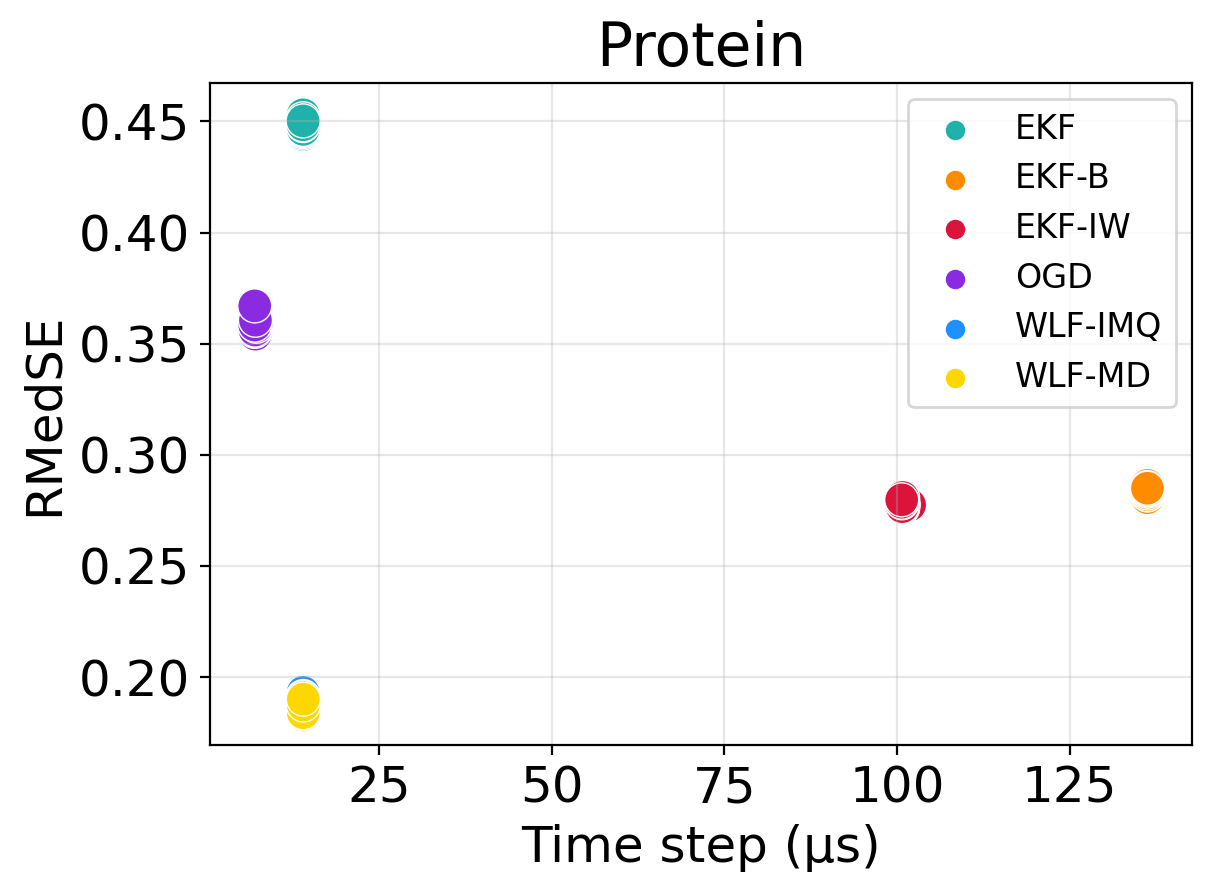

In [227]:
algorithms = sorted(cmap.keys())

dataset = "Protein"
sns.scatterplot(
    y="err", x="timestep", hue="method",
    data=df_results_all.query("dataset == @dataset").query("run > 0"),
    palette=cmap, s=150,
    hue_order=algorithms,
    linewidth=0.5,
)
# plt.yscale("log")
# plt.xscale("log")
plt.legend(ncol=1, loc="upper right", fontsize=12)
plt.title(dataset)
plt.xlabel("Time step (μs)")
plt.ylabel("RMedSE")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"./figures/{dataset.lower()}-time-v-err.png", dpi=300)

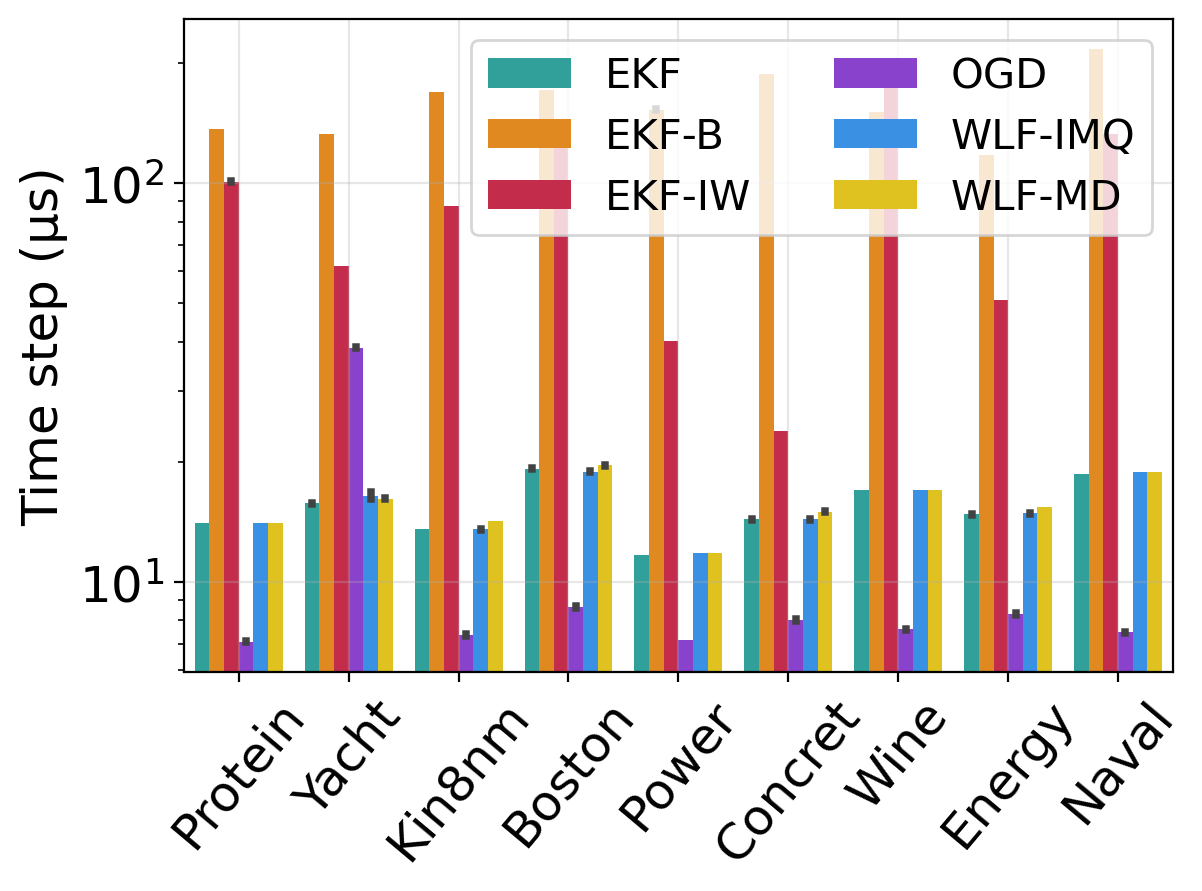

In [247]:
sns.barplot(
    x="dataset",
    y="timestep",
    hue="method",
    palette=cmap,
    data=(
        df_results_all.assign(dataset=df_results_all.dataset.str[:7].str.replace("nh", "n"))
    ),
)
plt.legend(ncol=2, fontsize=15, loc="upper right")
plt.xticks(rotation=50)
plt.grid(alpha=0.3)
plt.xlabel("")
plt.ylabel("Time step (μs)")
plt.tight_layout()
plt.yscale("log")
# plt.savefig(f"./figures/uci-time-comparison.png", dpi=300)

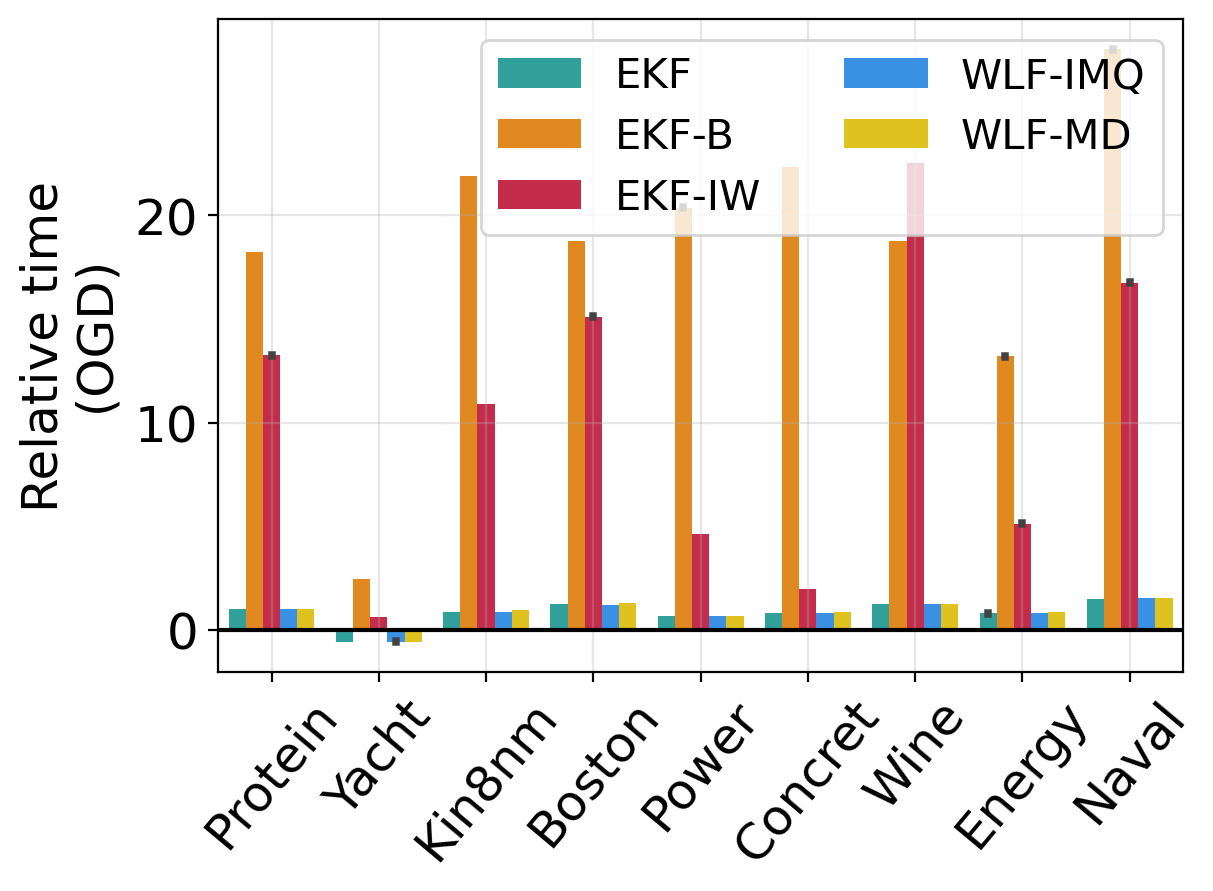

In [321]:
relative_to = "OGD"
metric = "time"
rel_metric = f"rel_{metric}"
timestep_ogd = df_results_all.query("method == @relative_to").groupby("dataset")[metric].mean()
df_results_all[rel_metric] = df_results_all.apply(lambda x: x[metric] / timestep_ogd[x["dataset"]] - 1, axis=1)

sns.barplot(
    x="dataset",
    y=rel_metric,
    hue="method",
    palette=cmap,
    data=(
        df_results_all
        .assign(dataset=df_results_all.dataset.str[:7].str.replace("nh", "n"))
        .query("method != @relative_to")
    ),
)
plt.legend(ncol=2, fontsize=15)
plt.axhline(y=0, c="black")
plt.xticks(rotation=50)
plt.grid(alpha=0.3)
plt.xlabel("")
plt.ylabel(f"Relative {metric}\n ({relative_to})")
plt.tight_layout()
# plt.yscale("log")
# plt.savefig(f"./figures/uci-rel-time-comparison.png", dpi=300)

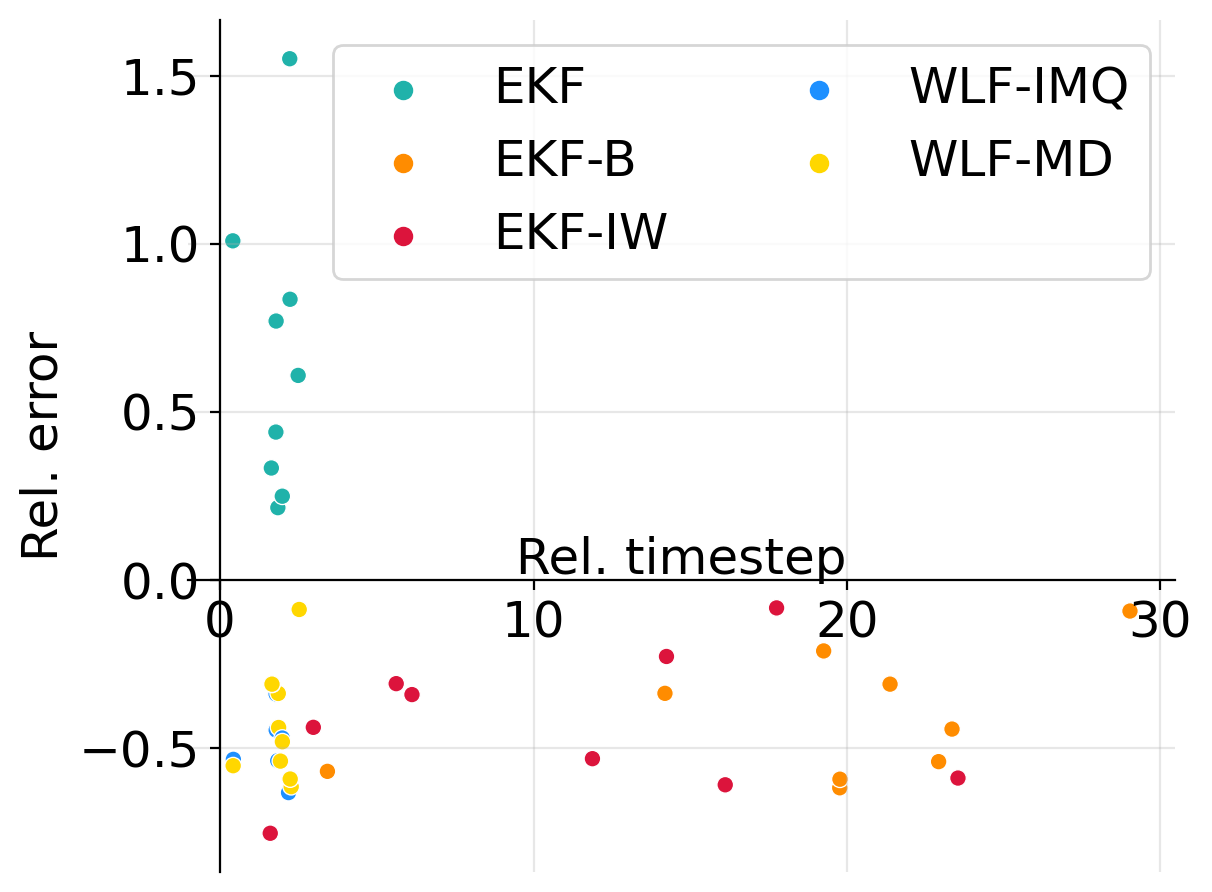

In [354]:
fig, ax = plt.subplots()
outp_df = df_results_all.groupby(["dataset", "method"])[["rel_timestep", "rel_err"]].mean().reset_index()
# outp_df = outp_df.melt(["dataset", "method"], var_name="metric")
sns.scatterplot(
    x="rel_timestep",
    y="rel_err",
    hue="method",
    data=outp_df.query("method != 'OGD'"),
    palette=cmap,
)
plt.grid(alpha=0.3)

ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)

plt.legend(ncol=2)
plt.xlabel("Rel. timestep", loc="center", labelpad=-40)
plt.ylabel("Rel. error")
plt.tight_layout()

In [269]:
df_results_all.pivot_table(index="method", columns="dataset", values="rel_timestep").style

dataset,Bostonhousing,Concrete,Energy,Kin8nm,Naval,Power,Protein,Wine,Yacht
method,,,,,,,,,
EKF,2.222993,1.788499,1.780879,1.843729,2.491242,1.636023,1.985548,2.232113,0.406885
EKF-B,19.767789,23.349618,14.192262,22.922558,29.026678,21.373010,19.255003,19.774339,3.424889
EKF-IW,16.115403,2.975211,6.121980,11.879033,17.753425,5.619250,14.240815,23.539387,1.601083
OGD,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
WLF-IMQ,2.184545,1.791010,1.788633,1.839919,2.520196,1.658061,1.985050,2.238018,0.424349
WLF-MD,2.269651,1.868494,1.857351,1.926256,2.524962,1.656723,1.987946,2.237519,0.418025


In [ ]:
df_results_all.pivot_table(index="method", columns="dataset", values="rel_err").style

dataset,Bostonhousing,Concrete,Energy,Kin8nm,Naval,Power,Protein,Wine,Yacht
method,,,,,,,,,
EKF,0.158448,0.094107,0.102416,0.070533,0.072547,0.072213,0.063588,0.099902,0.029084
EKF-B,0.023732,0.029591,0.047147,0.026688,0.040938,0.037390,0.040162,0.022188,0.006238
EKF-IW,0.024283,0.029866,0.046884,0.027199,0.041358,0.037471,0.039324,0.022373,0.003572
OGD,0.062125,0.053160,0.071122,0.058044,0.045101,0.054168,0.050900,0.054443,0.014478
WLF-IMQ,0.022842,0.029431,0.047013,0.026862,0.041168,0.037366,0.026971,0.022307,0.006755
WLF-MD,0.023941,0.029842,0.047128,0.026776,0.041148,0.037391,0.026417,0.022216,0.006482


<Axes: xlabel='rel_timestep', ylabel='rel_err'>

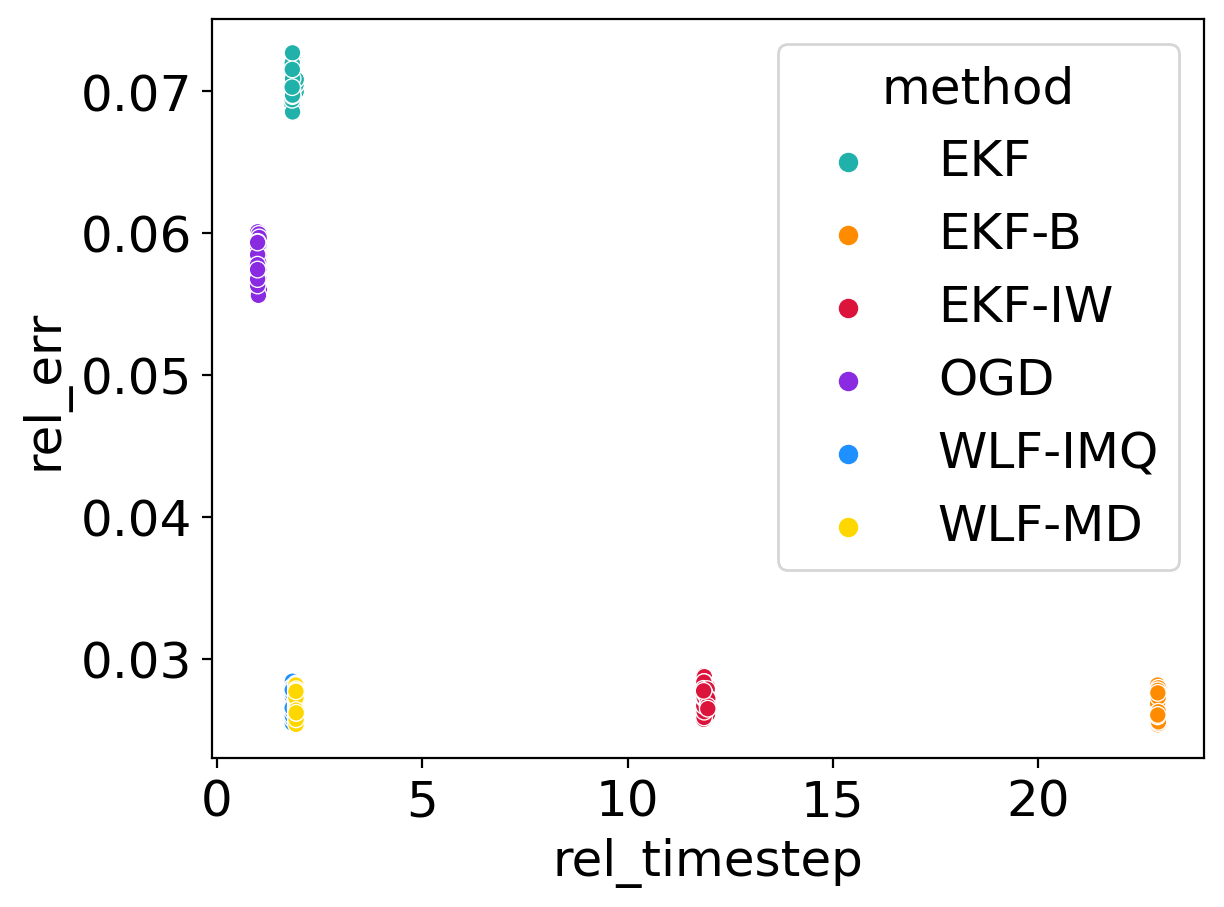

In [ ]:
dataset = "Kin8nm"
sns.scatterplot(
    x="rel_timestep",
    y="rel_err",
    hue="method",
    data=df_results_all.query("dataset == @dataset"),
    palette=cmap,
)

### Table of results

In [253]:
def format_entry(entry):
    # entry = entry[entry < 1000]
    mean = entry.mean()
    std = entry.std()
    if std > 1000:
        label = rf"$-$"
    else:
        label = rf"${mean:0.2f} \pm {std:0.2f}$"
    return label

In [254]:
res = (
    df_results_all
    .pivot_table(columns="method", index="dataset", values="err", aggfunc=format_entry)
)
res

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,$1.37 \pm 0.05$,$0.20 \pm 0.02$,$0.21 \pm 0.02$,$0.54 \pm 0.04$,$0.20 \pm 0.02$,$0.21 \pm 0.02$
Concrete,$0.75 \pm 0.03$,$0.24 \pm 0.01$,$0.24 \pm 0.01$,$0.43 \pm 0.02$,$0.24 \pm 0.01$,$0.24 \pm 0.01$
Energy,$0.85 \pm 0.04$,$0.39 \pm 0.02$,$0.39 \pm 0.02$,$0.59 \pm 0.03$,$0.39 \pm 0.02$,$0.39 \pm 0.02$
Kin8nm,$0.52 \pm 0.01$,$0.20 \pm 0.00$,$0.20 \pm 0.00$,$0.43 \pm 0.01$,$0.20 \pm 0.00$,$0.20 \pm 0.00$
Naval,$0.54 \pm 0.00$,$0.31 \pm 0.00$,$0.31 \pm 0.00$,$0.34 \pm 0.00$,$0.31 \pm 0.00$,$0.31 \pm 0.00$
Power,$0.52 \pm 0.01$,$0.27 \pm 0.01$,$0.27 \pm 0.01$,$0.39 \pm 0.01$,$0.27 \pm 0.01$,$0.27 \pm 0.01$
Protein,$0.45 \pm 0.00$,$0.28 \pm 0.00$,$0.28 \pm 0.00$,$0.36 \pm 0.00$,$0.19 \pm 0.00$,$0.19 \pm 0.00$
Wine,$0.76 \pm 0.05$,$0.17 \pm 0.03$,$0.17 \pm 0.03$,$0.41 \pm 0.06$,$0.17 \pm 0.03$,$0.17 \pm 0.03$
Yacht,$1.12 \pm 0.04$,$0.24 \pm 0.02$,$0.14 \pm 0.01$,$0.56 \pm 0.06$,$0.26 \pm 0.02$,$0.25 \pm 0.02$


In [256]:
print(res.style.to_latex(hrules=True).replace("_", "-"))

\begin{tabular}{lllllll}
\toprule
method & EKF & EKF-B & EKF-IW & OGD & WLF-IMQ & WLF-MD \\
dataset &  &  &  &  &  &  \\
\midrule
Bostonhousing & $1.37 \pm 0.05$ & $0.20 \pm 0.02$ & $0.21 \pm 0.02$ & $0.54 \pm 0.04$ & $0.20 \pm 0.02$ & $0.21 \pm 0.02$ \\
Concrete & $0.75 \pm 0.03$ & $0.24 \pm 0.01$ & $0.24 \pm 0.01$ & $0.43 \pm 0.02$ & $0.24 \pm 0.01$ & $0.24 \pm 0.01$ \\
Energy & $0.85 \pm 0.04$ & $0.39 \pm 0.02$ & $0.39 \pm 0.02$ & $0.59 \pm 0.03$ & $0.39 \pm 0.02$ & $0.39 \pm 0.02$ \\
Kin8nm & $0.52 \pm 0.01$ & $0.20 \pm 0.00$ & $0.20 \pm 0.00$ & $0.43 \pm 0.01$ & $0.20 \pm 0.00$ & $0.20 \pm 0.00$ \\
Naval & $0.54 \pm 0.00$ & $0.31 \pm 0.00$ & $0.31 \pm 0.00$ & $0.34 \pm 0.00$ & $0.31 \pm 0.00$ & $0.31 \pm 0.00$ \\
Power & $0.52 \pm 0.01$ & $0.27 \pm 0.01$ & $0.27 \pm 0.01$ & $0.39 \pm 0.01$ & $0.27 \pm 0.01$ & $0.27 \pm 0.01$ \\
Protein & $0.45 \pm 0.00$ & $0.28 \pm 0.00$ & $0.28 \pm 0.00$ & $0.36 \pm 0.00$ & $0.19 \pm 0.00$ & $0.19 \pm 0.00$ \\
Wine & $0.76 \pm 0.05$ & $0.17 \pm 0

In [258]:
(
    df_results_all
    .pivot_table(columns="method", index="dataset", values="err", aggfunc=lambda x: (x > 1000).sum())
)

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,0,0,0,0,0,0
Concrete,0,0,0,0,0,0
Energy,0,0,0,0,0,0
Kin8nm,0,0,0,0,0,0
Naval,0,0,0,0,0,0
Power,0,0,0,0,0,0
Protein,0,0,0,0,0,0
Wine,0,0,0,0,0,0
Yacht,0,0,0,0,0,0


## Store config 

In [235]:
dataset_name = "protein-tertiary-structure"
file_name = f"{dataset_name}-target-p-error10.pkl"
path = os.path.join(path_base, file_name)
with open(path, "rb") as f:
    experiment = pickle.load(f)
    hparams = experiment["config"].copy()

In [236]:
config = {}
p_error = experiment["p-error"]
dataset_name = experiment["dataset-name"]
config["metadata"] = {
    "p-error": p_error,
    "dataset-name": dataset_name,
}

config["hyperparams"] = hparams

In [237]:
filename_out = f"hparams-{dataset_name}-p-error{p_error * 100:0.0f}.toml"
filename_out

'hparams-protein-tertiary-structure-p-error10.toml'

In [238]:
path = os.path.join("configs", filename_out)
with open(path, "w") as f:
    toml.dump(config, f, encoder=toml.TomlNumpyEncoder())